<a href="https://colab.research.google.com/github/chernyavskaya/DeepLearn2022/blob/main/JetTagging_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jet Tagging with ParticleNet

In this tutorial we will implement a graph neural network for jet tagging. Jet tagging is a task of a jet classfication. 

We will represent each jet as a point cloud (or a "particle cloud") which consiststs of unordered set of jet's consistuent particles. Such a particle cloud representation of jets is efficient in incorporating raw information of jets and also explicitly respects the permutation symmetry. Based on the particle cloud representation, we will implement ParticleNet - a customized neural network architecture that uses Dynamic Graph Convolutional Neural Network : https://arxiv.org/abs/1902.08570. 

The task of jet tagging can be translated to graph classifcation task aiming to distinguish jets originating from quarks, gluons, W or Z bosons, or top quarks.

We will use PyTorch Geometric to build ParticleNet.

Before you start, choose GPU as a hardware accelerator for this notebook. To do this first go to Edit -> Notebook Settings -> Choose GPU as a hardware accelerator.


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 23.9 MB/s 
     |████████████████████████████████| 3.5 MB 23.4 MB/s 
     |████████████████████████████████| 2.4 MB 21.9 MB/s 


In [ ]:
# Helper function for visualization.
import matplotlib.pyplot as plt
%matplotlib inline
# Numpy, h5py, etc
import numpy as np
import h5py

Set up a GPU for the training and check how much memory is available.

In [ ]:
def print_device_usage(device):
  tot_memory = torch.cuda.get_device_properties(device).total_memory/1024.0**3
  reserved_memory = torch.cuda.memory_reserved(device)/1024.0**3
  allocated_memory = torch.cuda.memory_allocated(device)/1024.0**3
  free_memory = reserved_memory-allocated_memory  # free inside reserved
  print('Total memory in Gb: %.2f'%tot_memory)
  print('Reserved memory in Gb: %.2f'%reserved_memory)
  print('Allocated memory in Gb: %.2f'%allocated_memory)
  print('Free memory in Gb: %.2f'%free_memory)


# check if a GPU is available. Otherwise run on CPU
device = 'cpu'
args_cuda = torch.cuda.is_available()
if args_cuda: device = "cuda:0"
print('device : ',device)
if args_cuda: print_device_usage(device)

device :  cuda:0
Total memory in Gb: 14.76
Reserved memory in Gb: 0.00
Allocated memory in Gb: 0.00
Free memory in Gb: 0.00


# Dataset exploration

First, let's download the jet-tagging dataset

In [ ]:
! git clone https://github.com/chernyavskaya/DeepLearn2022.git
! ls DeepLearn2022/data

Cloning into 'DeepLearn2022'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15 (delta 0), reused 6 (delta 0), pack-reused 8
Unpacking objects: 100% (15/15), done.
jetImage_7_100p_0_10000.h5	jetImage_7_100p_40000_50000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_30000_40000.h5


In [ ]:
# let's open the file
data_dir = 'DeepLearn2022/data/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


*   'jetImage' ,' jetImageECAL' and 'jetImageHCAL' contains the image representation of the jets  . We will not use them today but build our point cloud from the other information.
*   'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored. This is the dataset we will consider in this notebook.
*   'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
*   'jets' is the list of jets with the high-level jet features stored. We will only use jet ID from it, indecies [-6:-1]
*   'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'. These quantities are build using physics knowledge and correspond to high-level infromation and features per graph (as opposed to per node)

The first 100 highest transverse momentum $p_T$ particles are considered for each jet.



In [ ]:
target = np.array([])
jetList = np.array([])
jetImages = np.array([])
features_names = dict()
datafiles = ['jetImage_7_100p_0_10000.h5',
             'jetImage_7_100p_10000_20000.h5',
             'jetImage_7_100p_30000_40000.h5',
             'jetImage_7_100p_40000_50000.h5',
             'jetImage_7_100p_50000_60000.h5'
            ]
for i_f,fileIN in enumerate(datafiles):
    print("Appending %s" %fileIN)
    f = h5py.File(data_dir + fileIN)
    jetList_file = np.array(f.get("jetConstituentList"))
    target_file = np.array(f.get('jets')[0:,-6:-1])
    jetImages_file = np.array(f.get('jetImage'))
    jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target = np.concatenate([target, target_file], axis=0) if target.size else target_file
    jetImages = np.concatenate([jetImages, jetImages_file], axis=0) if jetImages.size else jetImages_file
    del jetList_file, target_file, jetImages_file
    #save particles/nodes features names and their indecies in a dictionary
    if i_f==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

Appending jetImage_7_100p_0_10000.h5
Appending jetImage_7_100p_10000_20000.h5
Appending jetImage_7_100p_30000_40000.h5
Appending jetImage_7_100p_40000_50000.h5
Appending jetImage_7_100p_50000_60000.h5


The ground truth is incorporated in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form
*  [1, 0, 0, 0, 0] for gluons
*  [0, 1, 0, 0, 0] for quarks
*  [0, 0, 1, 0, 0] for W
*  [0, 0, 0, 1, 0] for Z 
*  [0, 0, 0, 0, 1] for top quarks

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems). These labels are the 'target' for our classification tasks. Let's convert it back to single-column encoding :


In [ ]:
print("Labels for the first five entries in the dataset, one-hot encoded:")
for i in range(5):
    print(target[i])
target = np.argmax(target, axis=1)
print("Labels for the first five entries in the dataset, single column encoded:")
for i in range(0,5):
    print(target[i])

Labels for the first five entries in the dataset, one-hot encoded:
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0.]
Labels for the first five entries in the dataset, single column encoded:
0
2
4
4
2


Now our lables correspond to :
*  0 for gluons
*  1 for quarks
*  2 for W
*  3 for Z 
*  4 for top quarks


In [ ]:
num_classes = len(np.unique(target))
label_names= ["gluon", "quark", "W", "Z", "top"]

Now let's inspect our data. Each jet is a point cloud/graph with 100 particles/nodes, each of which has 16 features. We have a double-index dataset: (jet index, particle index). The list is cut at 100 constituents per jet. If less constituents are present in the jet/point cloud, the dataset is completed filling it with 0s (zero padding). Note : zero-padding is not using during the training, it is only used to store the ragged dataset.



In [ ]:
print('Jets shape : ',jetList.shape)
print('Target/Labels shape : ',target.shape)
print('Particles/Nodes features : ',list(features_names.keys()))

Jets shape :  (50000, 100, 16)
Target/Labels shape :  (50000,)
Particles/Nodes features :  ['px', 'py', 'pz', 'e', 'erel', 'pt', 'ptrel', 'eta', 'etarel', 'etarot', 'phi', 'phirel', 'phirot', 'deltaR', 'costheta', 'costhetarel']


We are not interested in all features for now. For now we will only consider the same node features as were considered in the ParticleNet paper: 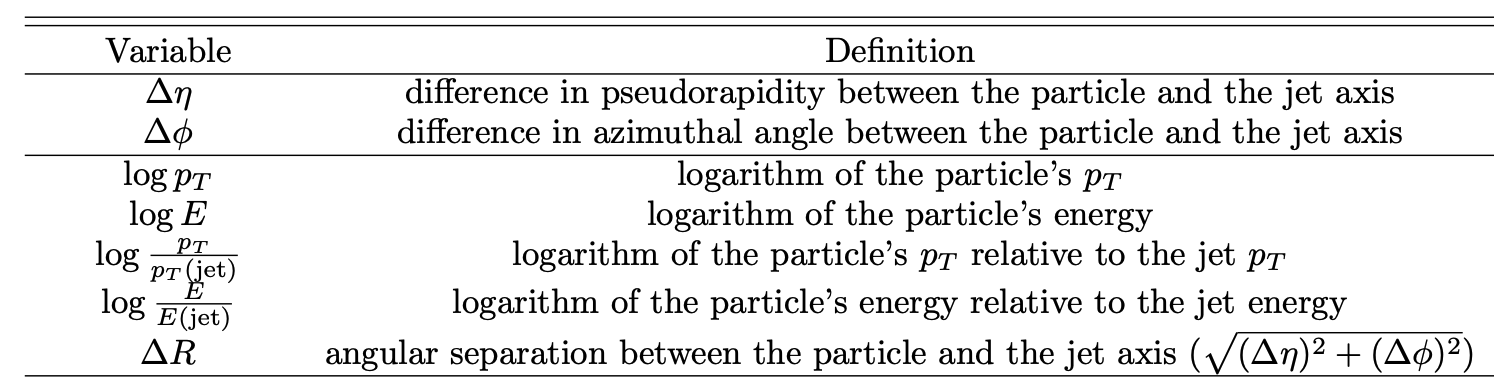

In [ ]:
features_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
jetList = jetList[:,:,features_idx]

# Jets as images
Jets can be converted to images considering the (η, φ) plane, centered along the axis direction and binned. In our case, we consider a square of 1.6x1.6 in size binned in 100x100 equal-size 'cells'. We will not use this data representation for our graph classification task, but looking at this representation helps better understanding what jet is. 



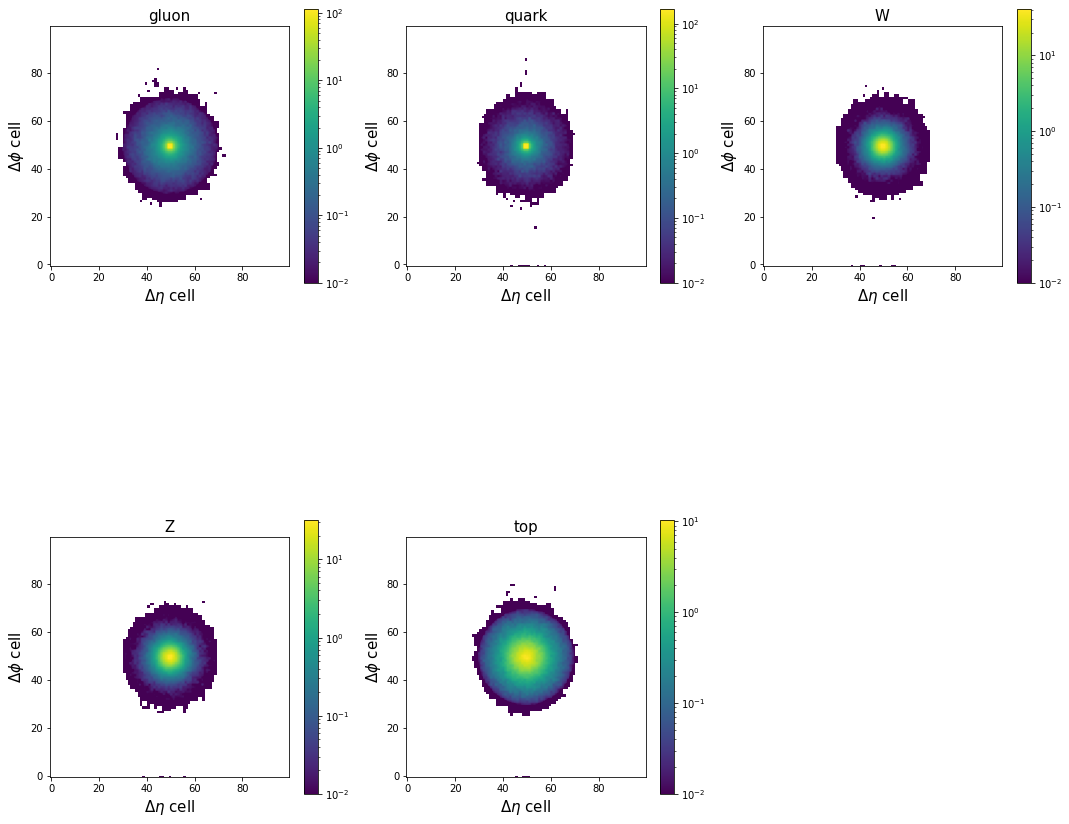

In [ ]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,15), tight_layout=True)
fig.delaxes(axes[-1, -1])
for i_l, label in enumerate(label_names):
    image = jetImages[target == i_l]
    SUM_Image = np.sum(image, axis = 0)
    im = axes.flat[i_l].imshow(SUM_Image/float(image.shape[0]), origin='lower',norm=LogNorm(vmin=0.01))
    fig.colorbar(im,ax=axes.flat[i_l],shrink=0.5)
    axes.flat[i_l].set_title(label_names[i_l], fontsize=15)
    axes.flat[i_l].set_xlabel(r"$\Delta\eta$ cell", fontsize=15)
    axes.flat[i_l].set_ylabel(r"$\Delta\phi$ cell", fontsize=15)
plt.show()


Now let's plot the disributions of the jets consituents (node features).

In [ ]:
#Let's define a helper function to plot the distibutions
def plot_features(feat_idx, input_data, features_to_consider):
    plt.subplots(figsize=(5,5))
    for jet_type_idx in range(len(label_names)):
        data_feature = input_data[:,:,feat_idx]
        data_feature = data_feature[target == jet_type_idx]
        # then plot the right quantity for the reduced array (merge all constituents together)
        plt.hist(data_feature[:,feat_idx].flatten(), bins=50, density=True, histtype='step', fill=False, linewidth=1.5)
    #plt.yscale('log', nonposy='clip')    
    plt.legend(label_names, fontsize=12, frameon=False)  
    plt.xlabel(features_to_consider[feat_idx], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()


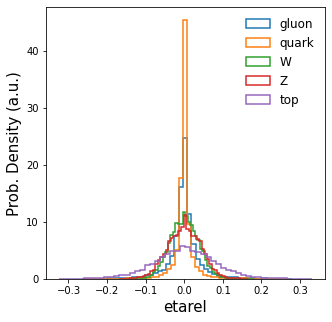

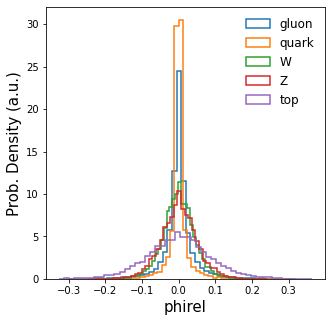

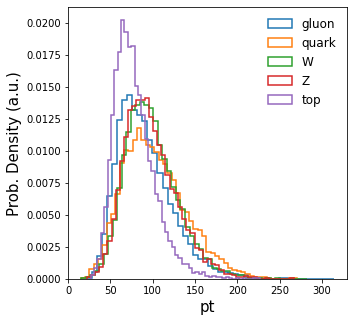

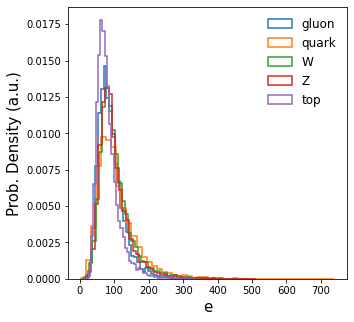

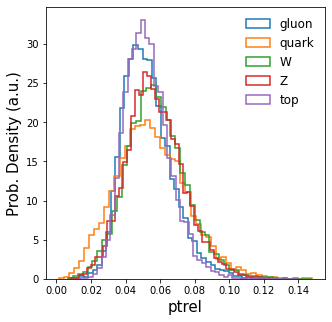

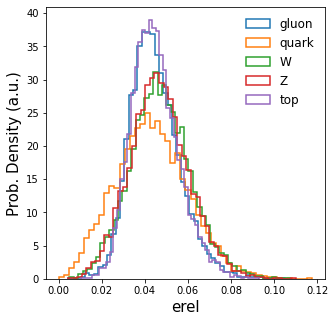

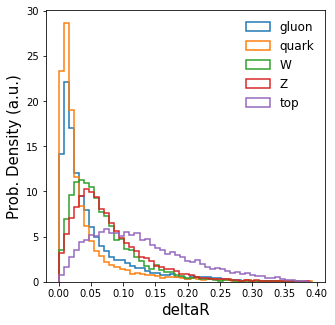

In [ ]:
# we now plot all the features
for i in range(len(features_to_consider)):
    plot_features(i, jetList, features_to_consider)


#Building ParticleNet




Now once we explored our dataset, let's build ParticleNet tagger with PyTorch Geometric. This is the architecture of ParticleNet that we already looked into in details :

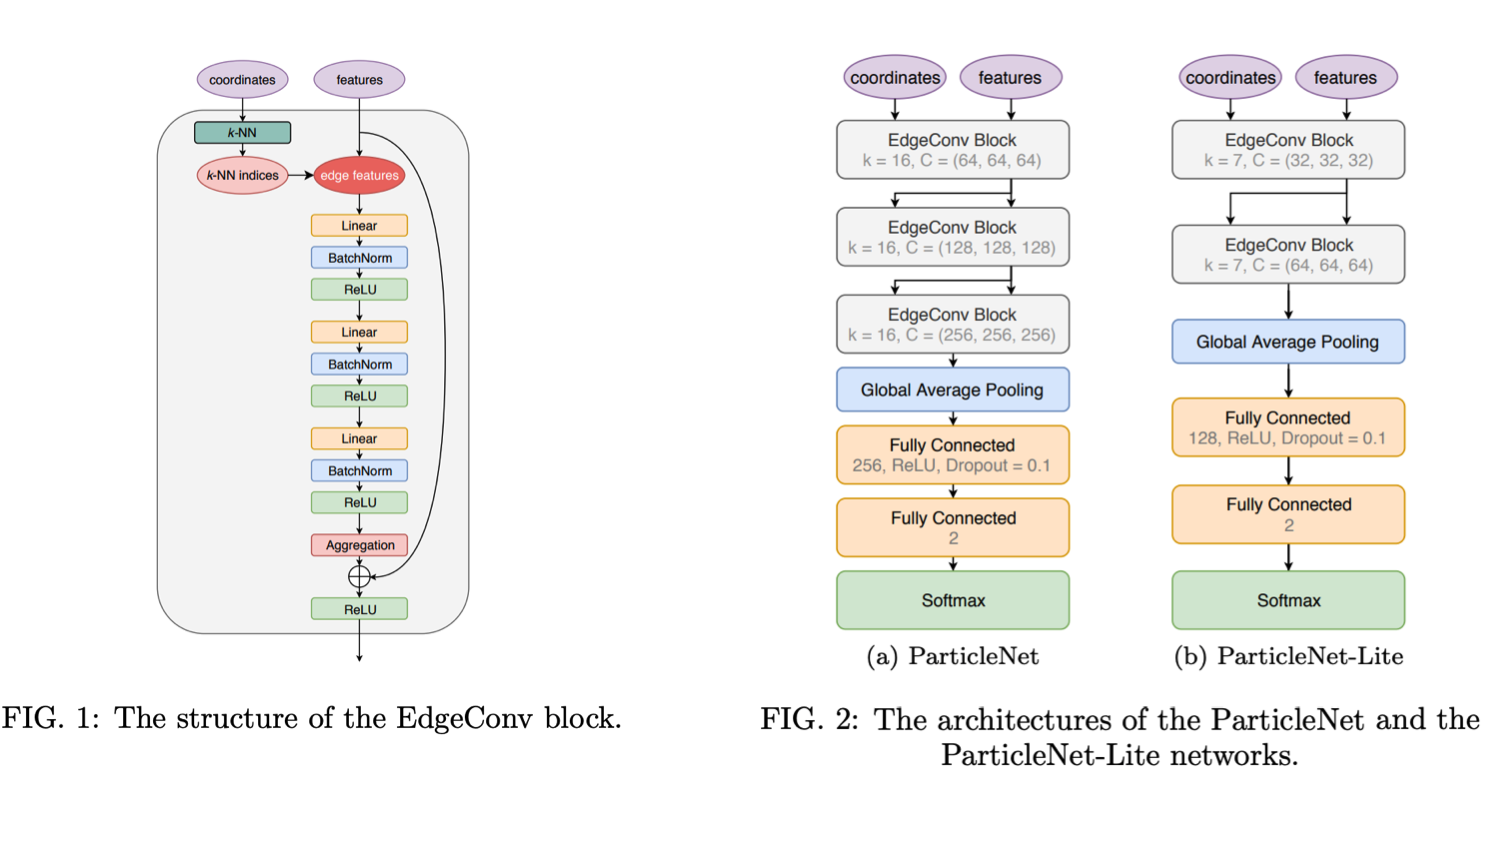

In [ ]:
from torch import nn
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch_cluster import knn_graph
import torch.nn.functional as F


class ParticleNetEdgeNet(nn.Module):
    def __init__(self, in_size, layer_size):
        super(ParticleNetEdgeNet, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(2):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.model)


class ParticleNet(nn.Module):
    def __init__(self, node_feat_size, num_classes=5):
        super(ParticleNet, self).__init__()
        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = 16
        self.num_edge_convs = 3
        self.kernel_sizes = [64, 128, 256]
        self.fc_size = 256
        self.dropout = 0.1

        self.edge_nets = nn.ModuleList()
        self.edge_convs = nn.ModuleList()

        self.kernel_sizes.insert(0, self.node_feat_size)
        self.output_sizes = np.cumsum(self.kernel_sizes)

        self.edge_nets.append(ParticleNetEdgeNet(self.node_feat_size, self.kernel_sizes[1]))
        self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        for i in range(1, self.num_edge_convs):
            # adding kernel sizes because of skip connections
            self.edge_nets.append(
                ParticleNetEdgeNet(self.output_sizes[i], self.kernel_sizes[i + 1])
            )
            self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        self.fc1 = nn.Sequential(nn.Linear(self.output_sizes[-1], self.fc_size))

        self.dropout_layer = nn.Dropout(p=self.dropout)

        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

    def forward(self, data):
        # input data is an instance of PyG Data() 
        x = data.x
        batch = data.batch

        for i in range(self.num_edge_convs):
            # using only angular coords eta and phi for knn in the first edgeconv block, computing edge_index.
            edge_index = (
                knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)
            )
            x = torch.cat(
                (self.edge_convs[i](x, edge_index), x), dim=1
            )  # concatenating with original features i.e. skip connection

        x = global_mean_pool(x, batch) # this runs scatter under the hood
        x = self.fc1(x)

        return self.fc2(x)  # no softmax because pytorch cross entropy loss includes softmax

In [ ]:
from torch_geometric.data import Data

num_jets = np.minimum(50000, len(jetList)) #number of training+validation samples. We can start with 10000.
jet_dataset = []
for i_jet in range(num_jets):
    # remove the zero padded particles
    mask_real = np.where(jetList[i_jet,:,features_to_consider.index('e')]>0) # keep only particles where energy is > 0. e.g. real particles
    num_nodes = len(mask_real[0])
    d = Data(x=torch.tensor(jetList[i_jet,mask_real,:].squeeze(), dtype=torch.float), 
             y=torch.tensor(target[i_jet], dtype=torch.long),
             num_nodes = num_nodes)
    # typically we do no need to set the num_nodes explicitely and it is inferred automatically from the edge_index. 
    # however, in this case we do not pass edge_index, since we will build the graph dynamically inside the network, so we need to pass num_nodes.
    jet_dataset.append(d)


Let's have a look at the first 5 graphs (jets) : 

In [ ]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# split the resulting dataset in training and validation datasets
dataset_size = len(jet_dataset)
val_split = 0.1
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size
jet_dataset_train, jet_dataset_val = train_test_split(jet_dataset,test_size = val_size,train_size = train_size, shuffle=True)

# create dataloaders
batch_size = 128
jets_loader_train = DataLoader(jet_dataset_train, batch_size=batch_size,shuffle=True)
jets_loader_val = DataLoader(jet_dataset_val, batch_size=batch_size,shuffle=True)

Let's have a look at what is yielded by the DataLoader

In [ ]:
for data in jets_loader_val:
  print(data)
  print(data.batch)
  break

DataBatch(x=[5990, 7], y=[128], num_nodes=5990, batch=[5990], ptr=[129])
tensor([  0,   0,   0,  ..., 127, 127, 127])


Now let's instantiate the model, define optimizer and the loss function. 

In [ ]:
#Instantiate the model and move it to the device, define the optimizer and the loss function
import torch.optim as optim

gnn = ParticleNet(node_feat_size=len(features_to_consider), num_classes=num_classes)
#print(gnn)
gnn.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnn.parameters(), lr = 0.001)

Let's add a helper function that will count how many trainable parameters are in our graph neural network 

In [ ]:
def gnn_model_summary(model):
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [ ]:
gnn_model_summary(gnn)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
edge_nets.0.model.0.weight                   [64, 14]             896
edge_nets.0.model.0.bias                       [64]              64
edge_nets.0.model.1.weight                       [64]              64
edge_nets.0.model.1.bias                       [64]              64
edge_nets.0.model.3.weight                   [64, 64]            4096
edge_nets.0.model.3.bias                       [64]              64
edge_nets.0.model.4.weight                       [64]              64
edge_nets.0.model.4.bias                       [64]              64
edge_nets.0.model.6.weight                   [64, 64]            4096
edge_nets.0.model.6.bias                       [64]              64
edge_nets.0.model.7.weight                       [64]              64
edge_nets.0.model.7.bias                      

Now let's define the training and testing functions 

In [ ]:
import tqdm
# A small library to make your loops show a smart progress meter. To use it, just wrap any iterable with tqdm(iterable), and you're done!
#We will use it to see the progress of training one epoch over all batches.

In [ ]:
def train_test_one_epoch(model,jets_loader, mode='train'):
    if mode=='train':
        model.train(True)
    else:
        model.train(False)

    running_loss, running_correct = 0.,0.
    tot_iter = len(jets_loader)
    t = tqdm.tqdm(enumerate(jets_loader),total=tot_iter)
    for i, data in t:
        inputs = data # For the inputs we are passing the whole Data() object
        labels = data.y
        inputs = inputs.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad() # Clear gradients
        outputs = gnn(inputs) # Perform a single forward pass
        loss = loss_fn(outputs, labels) # Compute the loss
        if mode=='train':
            loss.backward()  # Derive gradients
            optimizer.step() # Update parameters based on gradients.

        running_loss += loss.item() #.item() returns average loss over the batch 
        del loss
        _, predicted = torch.max(F.softmax(outputs,dim=1).data, dim=1) # Adding softmax since there is none in the model, and taking the index of the highest probability.
        running_correct += float(torch.sum(predicted == labels.data))

    epoch_loss = running_loss / tot_iter
    epoch_acc = running_correct / (tot_iter*batch_size) 

    return epoch_loss,epoch_acc

In [ ]:
EPOCHS = 20

loss_train, loss_val = [],[]
acc_train, acc_val = [],[]
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    loss_train_epoch,acc_train_epoch = train_test_one_epoch(gnn,jets_loader_train,mode = 'train')
    loss_val_epoch,acc_val_epoch = train_test_one_epoch(gnn,jets_loader_val,mode = 'test')

    print('LOSS train {:.3f}, valid {:.3f}'.format(loss_train_epoch, loss_val_epoch))
    print('ACCURACY train {:.3f}, valid {:.3f}'.format(acc_train_epoch, acc_val_epoch))

    loss_train.append(loss_train_epoch)
    loss_val.append(loss_val_epoch)
    acc_train.append(acc_train_epoch)
    acc_val.append(acc_val_epoch)


EPOCH 1:


100%|██████████| 40/40 [00:01<00:00, 20.46it/s]


LOSS train 1.088, valid 1.134
ACCURACY train 0.538, valid 0.524
EPOCH 2:


100%|██████████| 40/40 [00:01<00:00, 20.16it/s]


LOSS train 0.940, valid 0.921
ACCURACY train 0.615, valid 0.600
EPOCH 3:


100%|██████████| 40/40 [00:01<00:00, 20.20it/s]


LOSS train 0.893, valid 0.863
ACCURACY train 0.645, valid 0.640
EPOCH 4:


100%|██████████| 40/40 [00:01<00:00, 20.35it/s]


LOSS train 0.868, valid 0.883
ACCURACY train 0.659, valid 0.629
EPOCH 5:


100%|██████████| 40/40 [00:01<00:00, 20.07it/s]


LOSS train 0.844, valid 0.809
ACCURACY train 0.674, valid 0.663
EPOCH 6:


100%|██████████| 40/40 [00:01<00:00, 20.41it/s]


LOSS train 0.824, valid 0.801
ACCURACY train 0.682, valid 0.673
EPOCH 7:


100%|██████████| 40/40 [00:01<00:00, 20.27it/s]


LOSS train 0.813, valid 0.939
ACCURACY train 0.691, valid 0.578
EPOCH 8:


100%|██████████| 40/40 [00:02<00:00, 17.95it/s]


LOSS train 0.801, valid 0.864
ACCURACY train 0.694, valid 0.630
EPOCH 9:


100%|██████████| 40/40 [00:01<00:00, 20.31it/s]


LOSS train 0.787, valid 1.062
ACCURACY train 0.702, valid 0.578
EPOCH 10:


100%|██████████| 40/40 [00:01<00:00, 20.24it/s]


LOSS train 0.777, valid 0.790
ACCURACY train 0.707, valid 0.683
EPOCH 11:


100%|██████████| 40/40 [00:01<00:00, 20.34it/s]


LOSS train 0.770, valid 0.958
ACCURACY train 0.709, valid 0.613
EPOCH 12:


100%|██████████| 40/40 [00:01<00:00, 20.37it/s]


LOSS train 0.768, valid 0.751
ACCURACY train 0.710, valid 0.702
EPOCH 13:


100%|██████████| 40/40 [00:01<00:00, 20.12it/s]


LOSS train 0.754, valid 1.824
ACCURACY train 0.721, valid 0.442
EPOCH 14:


100%|██████████| 40/40 [00:01<00:00, 20.34it/s]


LOSS train 0.747, valid 0.762
ACCURACY train 0.719, valid 0.696
EPOCH 15:


100%|██████████| 40/40 [00:01<00:00, 20.38it/s]


LOSS train 0.733, valid 0.835
ACCURACY train 0.729, valid 0.666
EPOCH 16:


100%|██████████| 40/40 [00:01<00:00, 20.27it/s]


LOSS train 0.733, valid 0.772
ACCURACY train 0.727, valid 0.684
EPOCH 17:


100%|██████████| 40/40 [00:01<00:00, 20.30it/s]


LOSS train 0.720, valid 1.103
ACCURACY train 0.735, valid 0.595
EPOCH 18:


100%|██████████| 40/40 [00:01<00:00, 20.40it/s]


LOSS train 0.715, valid 0.828
ACCURACY train 0.738, valid 0.672
EPOCH 19:


100%|██████████| 40/40 [00:01<00:00, 20.22it/s]


LOSS train 0.699, valid 1.018
ACCURACY train 0.746, valid 0.612
EPOCH 20:


100%|██████████| 40/40 [00:01<00:00, 20.28it/s]

LOSS train 0.696, valid 0.920
ACCURACY train 0.748, valid 0.634


Let's plot evaluation of training and validation loss and accuracy with epochs.

In [ ]:
#First we define a helper function
def draw_metric_evolution():
  epoch_number = list(range(EPOCHS))
  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,6), tight_layout=True)
  axes.flat[0].plot(epoch_number, loss_train,label='Training ')
  axes.flat[0].plot(epoch_number, loss_val,label='Validation ')
  axes.flat[0].set_ylabel("Loss",fontsize=15)
  axes.flat[0].legend(loc='upper right',fontsize=15,frameon=False)

  axes.flat[1].plot(epoch_number, acc_train,label='Training ')
  axes.flat[1].plot(epoch_number, acc_val,label='Validation ')
  axes.flat[1].set_ylabel("Accuracy",fontsize=15)
  axes.flat[1].legend(loc='upper left',fontsize=15,frameon=False)

  for i in [0,1]:
    axes.flat[i].set_xlabel("Epoch",fontsize=15)
    axes.flat[i].grid(True)

  plt.show()

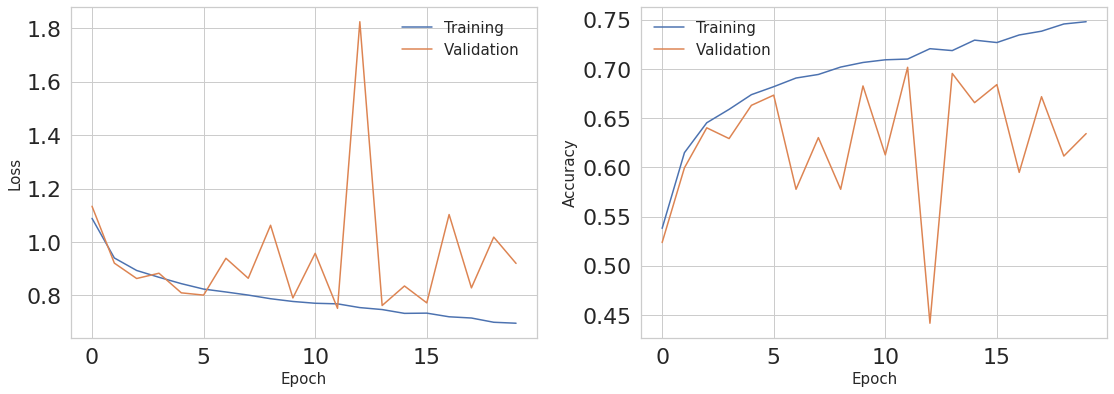

In [ ]:
draw_metric_evolution()

Now let's evaluate how our model performs on the validation dataset by calculating accuracy for each jet type and building the ROC curve.


In [ ]:
pred_val = []
pred_label = []
true_label = []
for i, data in enumerate(jets_loader_val):
    inputs, labels = data, data.y
    inputs = inputs.to(device)
    # there is no softmax in the output layer. We have to put it. 
    pred_val.append(F.softmax(gnn(inputs.to(device)), dim=1).cpu().detach().numpy())
    pred_label.append(np.argmax(pred_val[i],axis=1))
    true_label.append(labels.numpy())
pred_val = np.concatenate(pred_val, axis=0)
pred_label = np.concatenate(pred_label, axis=0)
true_label = np.concatenate(true_label,axis=0)

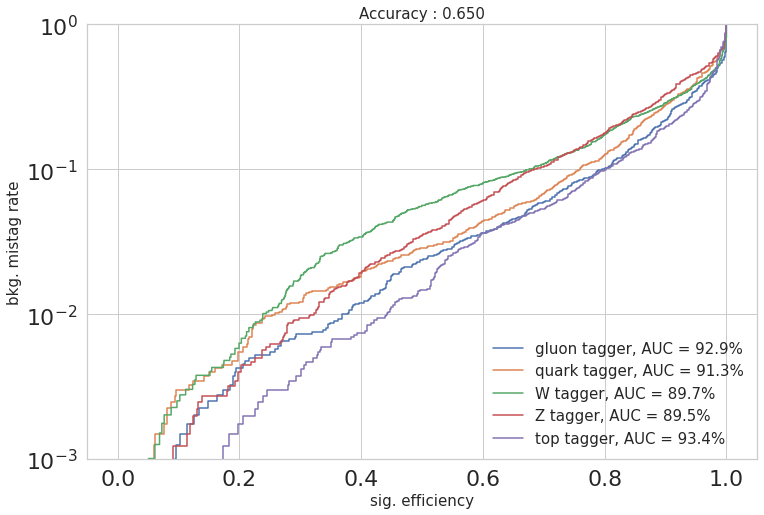

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score

#### get the ROC curves
fpr = {}
tpr = {}
auc_value = {}
plt.figure(figsize=(12,8))
for i, label in enumerate(label_names):
    fpr[label], tpr[label], threshold = roc_curve((true_label== i), pred_val[:,i])
    auc_value[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label,auc_value[label]*100.))
#computing accuracy now
acc_score = accuracy_score(true_label, pred_label)
acc_manual = np.sum(pred_label == true_label)
plt.title('Accuracy : {:.3f}'.format(acc_score), fontsize=15)
plt.semilogy()
plt.xlabel("sig. efficiency",fontsize=15)
plt.ylabel("bkg. mistag rate",fontsize=15)
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower right',fontsize=15, frameon=False)
plt.show()





Now let's evaluate confusion matrix

In [ ]:
# First we define a helper function
import seaborn as sns
sns.set_style("whitegrid")

def plot_matrix(cm, classes, title):
  plt.figure(figsize = (12,12))  
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False)
  ax.set(title=title, xlabel="Predicted label", ylabel="True label")

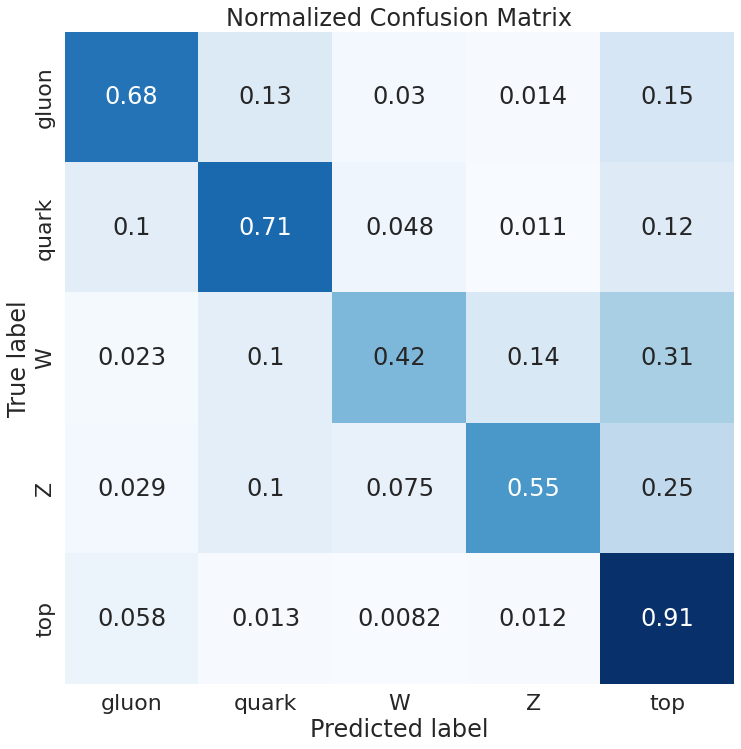

In [ ]:
#Evaluate confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_label, pred_label,normalize = 'true')
plot_matrix(cm, label_names, title = 'Normalized Confusion Matrix')

We can see that overall performance is not bad, however W and Z are often confused.

## Additional Optional Exercises

1. You can try to improve perfomance further by increasing the number of EdgeConvs blocks, the dimensionality of the layers inside them, as well as the number of neurons in the FC layers. Does it help at all?

2. Instead of building the graph connectivity from $\eta$ and $\phi$ coordinates only (the first kNN), you can try to use directly [DynamicEdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.DynamicEdgeConv) layer from PyG that will evaluate kNN from all input features. Do you see any change in the performance? 